<a href="https://colab.research.google.com/github/beimnet777/Deep_Learning_Lab/blob/main/Project/Classification_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the neccessary Libraries to build and train the model

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# Mounting Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Visualizing some of the data

In [32]:
images = []

for filename in os.listdir("/content/drive/MyDrive/Normal/train_transformed (1)"):
    if filename.endswith(".jpg"):
        image_path = os.path.join("/content/drive/MyDrive/Normal/train_transformed (1)", filename)
        image = Image.open(image_path).convert('RGB')
        images.append((image,filename[:3]))


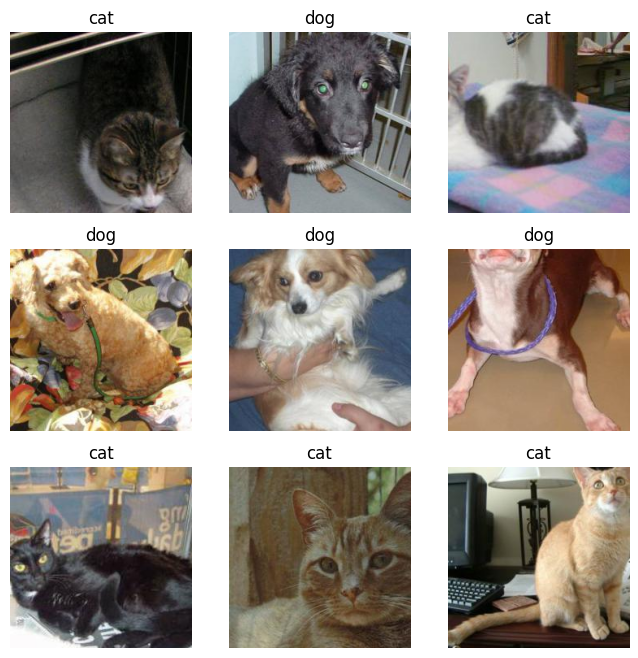

In [33]:
import numpy as np

num_images_to_display = 9
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(num_images_to_display):
    ax = axes[i // 3, i % 3]
    ax.imshow(np.array(images[i][0]))
    ax.set_title(images[i][1])
    ax.axis('off')

plt.show()

In [ ]:
num_images_to_display = 9
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(num_images_to_display):
    ax = axes[i // 3, i % 3]
    ax.imshow(np.array(cat_images[i]))
    ax.set_title("Cat")
    ax.axis('off')

plt.show()

# Define a custom DataSet
This code defines a custom PyTorch Dataset class, 'CatDogDataset,' tailored for binary classification tasks with cat and dog images. The dataset is organized in a specified directory, where images are labeled 'cat' or 'dog' based on their file names. The class simplifies image loading, label assignment, and optional data transformations, making it suitable for training machine learning models using PyTorch's DataLoader

In [2]:
class CustomDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.directory, img_name)
        image = Image.open(img_path).convert('RGB')
        label = 0 if img_name.startswith('cat') else 1

        if self.transform:
            image = self.transform(image)

        return image, label

# Defining A Simple (but effective) CNN Model

In [34]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Output: [128, 128, 16] after pooling
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # Output: [64, 64, 32] after pooling
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # Output: [32, 32, 64] after pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 64, 128)  # Correct number of input features
        self.fc2 = nn.Linear(128, 1)  # Single output for binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 32 * 32 * 64)  # Flatten the output for the dense layer
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid to output probabilities
        return x


# Data Loading and Preprocessing

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Plotting Function
Defining A function that will plot the Accuracy and Loss accross a given epochs

In [6]:
def plot(accuracy_history, loss_history):
  num_epochs = len(accuracy_history)
  # plt loss
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_epochs+1), loss_history, marker='o', linestyle='-', color='b')
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.show()

  # Plot accuracy
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_epochs+1), accuracy_history, marker='o', linestyle='-', color='g')
  plt.title('Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.grid(True)
  plt.show()


# Model Training
Give Set of Hyper Parameters this function trains a model. The only requried parameter is the number of epochs, the other are optional parameter which will be useful in the later section

In [19]:
def train_model(epochs, lr = 0.001, batch_size=128):
  dataset = CustomDataset('/content/drive/MyDrive/Normal/train_transformed (1)', transform=transform)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  model = CNNModel().to(device)
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss_history = []
  accuracy_history = []

  for epoch in range(epochs):
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in loader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs).squeeze(1)  # Squeeze the second dimension explicitly
          loss = criterion(outputs, labels.float())
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          predicted = outputs >= 0.5  # Using threshold of 0.5 to determine class
          correct += (predicted == labels).sum().item()
          total += labels.size(0)

      epoch_loss = running_loss / len(loader)
      epoch_accuracy = (correct / total) * 100
      loss_history.append(epoch_loss)
      accuracy_history.append(epoch_accuracy)
      print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
  plot(accuracy_history, loss_history)

  #saving model

  path = "model" + "lr_" +str(lr) + "batch_" + str(batch_size) + "epoch_" + str(epoch)
  torch.save(model.state_dict(), path)


# Training model with default hyper parameter

Epoch 1, Loss: 0.7216, Accuracy: 50.30%
Epoch 2, Loss: 0.6916, Accuracy: 51.75%
Epoch 3, Loss: 0.6812, Accuracy: 57.75%
Epoch 4, Loss: 0.6814, Accuracy: 56.05%
Epoch 5, Loss: 0.6740, Accuracy: 56.50%
Epoch 6, Loss: 0.6588, Accuracy: 61.50%
Epoch 7, Loss: 0.6536, Accuracy: 61.25%
Epoch 8, Loss: 0.6390, Accuracy: 63.40%
Epoch 9, Loss: 0.6152, Accuracy: 65.65%
Epoch 10, Loss: 0.5778, Accuracy: 69.65%
Epoch 11, Loss: 0.5487, Accuracy: 71.35%
Epoch 12, Loss: 0.5004, Accuracy: 75.90%
Epoch 13, Loss: 0.4664, Accuracy: 77.95%
Epoch 14, Loss: 0.3910, Accuracy: 82.75%
Epoch 15, Loss: 0.3313, Accuracy: 85.35%


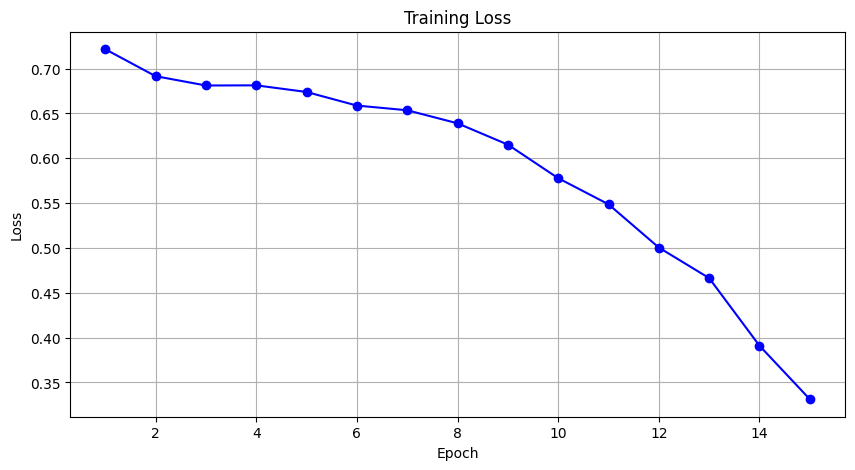

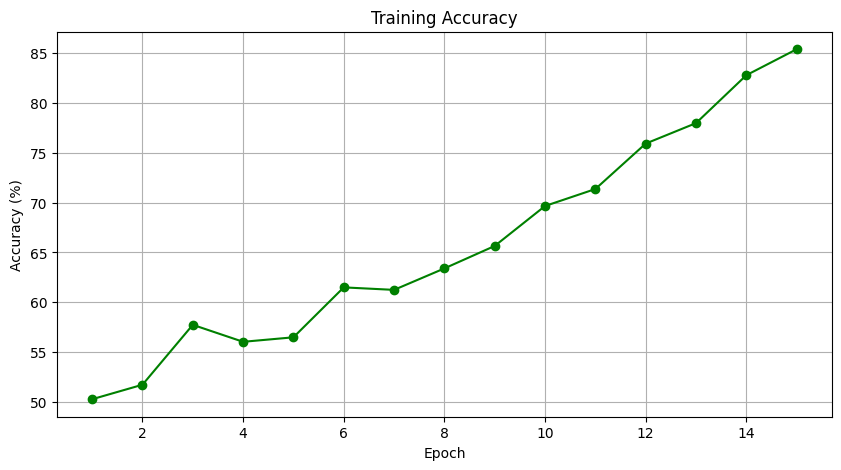

In [20]:
train_model(15, lr = 0.001, batch_size=128)

# Training Model with Different Batch Size
For Batch size of 32, 64 and 128

**Batch size = 32**

Epoch 1, Loss: 0.6996, Accuracy: 51.35%
Epoch 2, Loss: 0.6804, Accuracy: 56.25%
Epoch 3, Loss: 0.6681, Accuracy: 59.20%
Epoch 4, Loss: 0.6613, Accuracy: 60.60%
Epoch 5, Loss: 0.6323, Accuracy: 63.55%
Epoch 6, Loss: 0.5509, Accuracy: 71.95%
Epoch 7, Loss: 0.4497, Accuracy: 78.05%
Epoch 8, Loss: 0.3355, Accuracy: 85.20%
Epoch 9, Loss: 0.2272, Accuracy: 90.40%
Epoch 10, Loss: 0.1175, Accuracy: 95.50%
Epoch 11, Loss: 0.0548, Accuracy: 98.15%
Epoch 12, Loss: 0.0623, Accuracy: 98.25%
Epoch 13, Loss: 0.0763, Accuracy: 97.65%
Epoch 14, Loss: 0.0181, Accuracy: 99.60%
Epoch 15, Loss: 0.0075, Accuracy: 99.90%


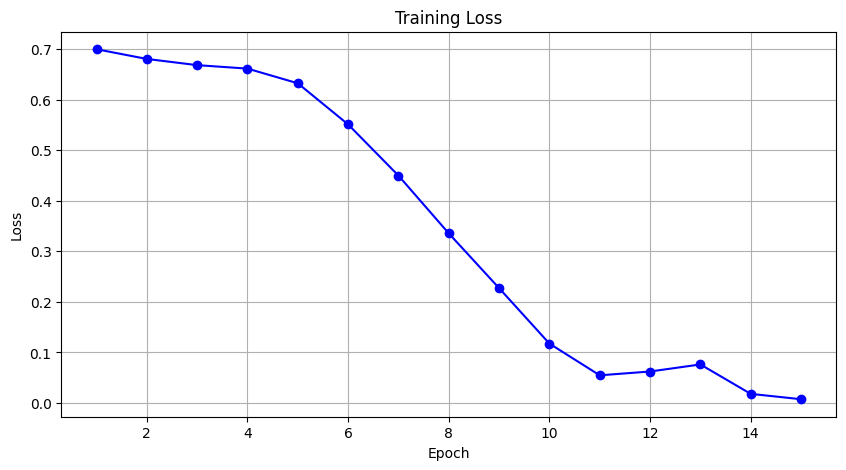

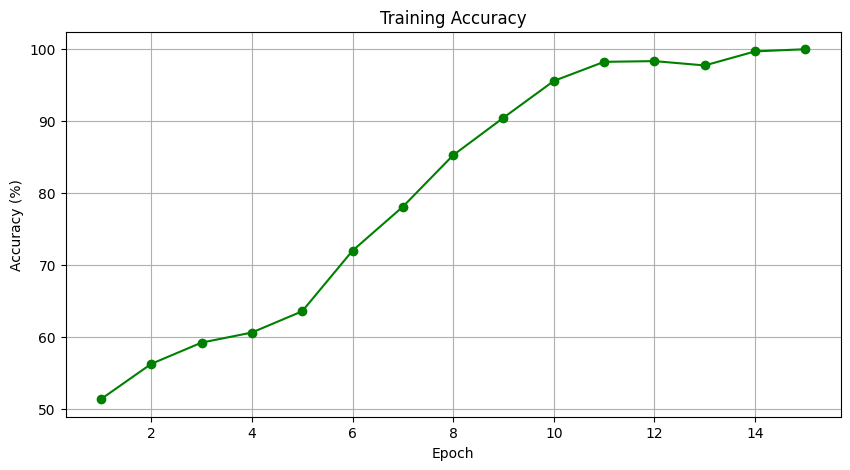

In [21]:
train_model(15, lr = 0.001, batch_size=32)

**Batch size = 64**

Epoch 1, Loss: 0.7236, Accuracy: 50.15%
Epoch 2, Loss: 0.6782, Accuracy: 54.80%
Epoch 3, Loss: 0.6669, Accuracy: 60.40%
Epoch 4, Loss: 0.6356, Accuracy: 64.95%
Epoch 5, Loss: 0.5949, Accuracy: 69.10%
Epoch 6, Loss: 0.5477, Accuracy: 72.20%
Epoch 7, Loss: 0.4740, Accuracy: 78.40%
Epoch 8, Loss: 0.3803, Accuracy: 83.65%
Epoch 9, Loss: 0.3027, Accuracy: 86.50%
Epoch 10, Loss: 0.2124, Accuracy: 91.80%
Epoch 11, Loss: 0.1379, Accuracy: 94.95%
Epoch 12, Loss: 0.1092, Accuracy: 96.15%
Epoch 13, Loss: 0.0520, Accuracy: 98.45%
Epoch 14, Loss: 0.0327, Accuracy: 98.80%
Epoch 15, Loss: 0.0429, Accuracy: 98.85%


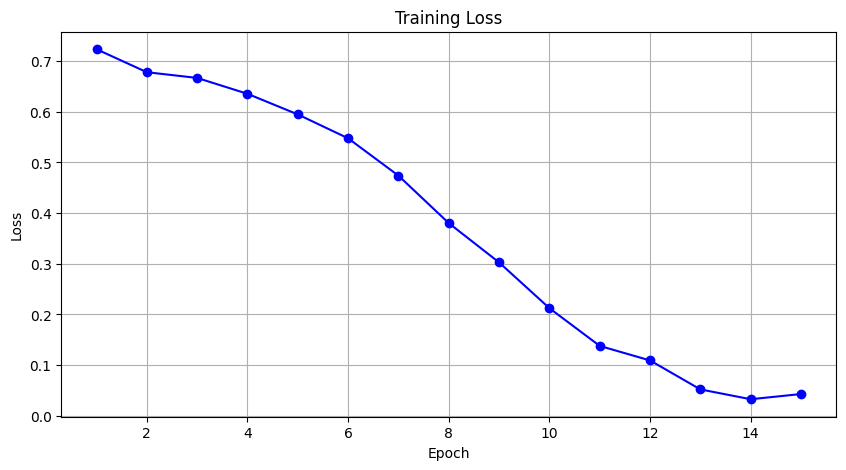

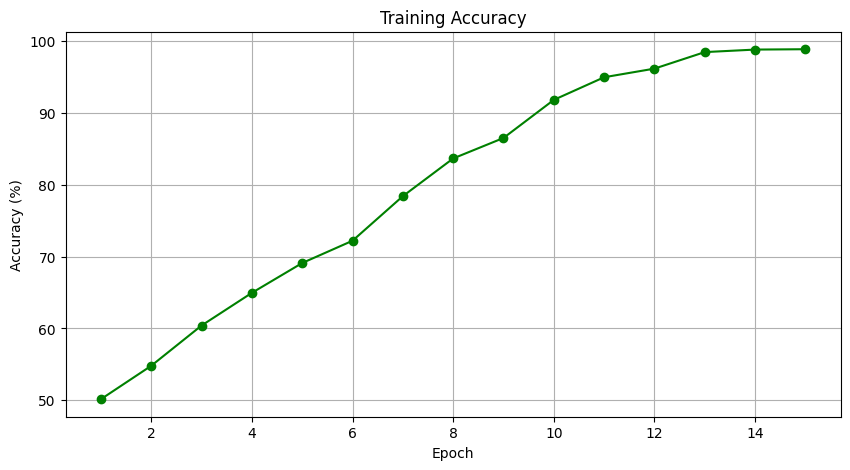

In [22]:
train_model(15, lr = 0.001, batch_size=64)

**Batch size  = 128**
**Since this batch size is the default batch size we can expect the result to be similar to the result**

# Training Model with Different Learning Rates
For learning rate of 0.1, 0.01, 0.001
since the best batch size was 32 we will be using batch size of 32 from now on

**Learning_Rate = 0.1**

Epoch 1, Loss: 49.1677, Accuracy: 50.00%
Epoch 2, Loss: 50.0000, Accuracy: 50.00%
Epoch 3, Loss: 49.9008, Accuracy: 50.00%
Epoch 4, Loss: 50.0496, Accuracy: 50.00%
Epoch 5, Loss: 50.0992, Accuracy: 50.00%
Epoch 6, Loss: 49.8016, Accuracy: 50.00%
Epoch 7, Loss: 50.0496, Accuracy: 50.00%
Epoch 8, Loss: 49.8016, Accuracy: 50.00%
Epoch 9, Loss: 50.0992, Accuracy: 50.00%
Epoch 10, Loss: 49.9008, Accuracy: 50.00%
Epoch 11, Loss: 49.9504, Accuracy: 50.00%
Epoch 12, Loss: 50.0992, Accuracy: 50.00%
Epoch 13, Loss: 49.9504, Accuracy: 50.00%
Epoch 14, Loss: 50.0992, Accuracy: 50.00%
Epoch 15, Loss: 49.8512, Accuracy: 50.00%


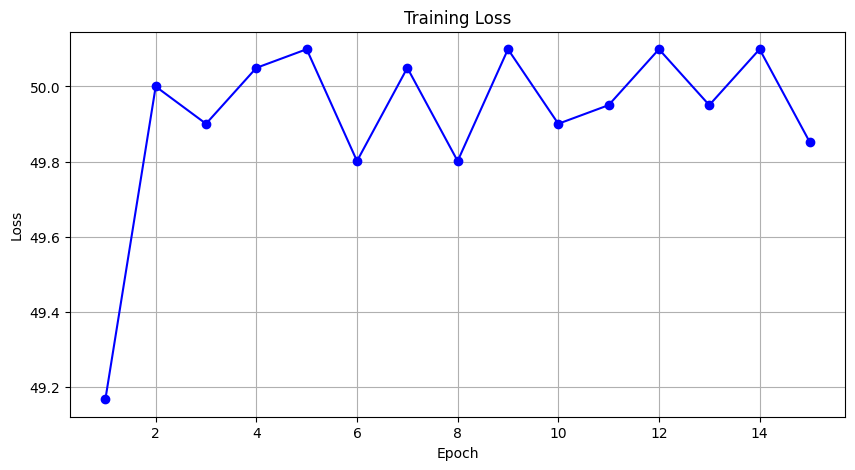

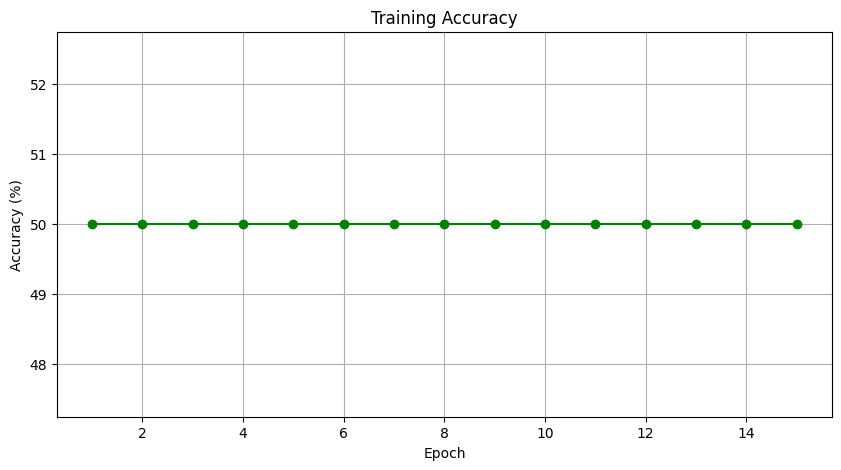

In [23]:
train_model(15, lr = 0.1, batch_size=32)

**Learning_Rate = 0.01**

Epoch 1, Loss: 49.2670, Accuracy: 50.00%
Epoch 2, Loss: 49.9008, Accuracy: 50.00%
Epoch 3, Loss: 49.8512, Accuracy: 50.00%
Epoch 4, Loss: 50.2480, Accuracy: 50.00%
Epoch 5, Loss: 50.0000, Accuracy: 50.00%
Epoch 6, Loss: 49.9504, Accuracy: 50.00%
Epoch 7, Loss: 50.0000, Accuracy: 50.00%
Epoch 8, Loss: 49.9008, Accuracy: 50.00%
Epoch 9, Loss: 49.9504, Accuracy: 50.00%
Epoch 10, Loss: 49.9504, Accuracy: 50.00%
Epoch 11, Loss: 50.0496, Accuracy: 50.00%
Epoch 12, Loss: 49.9504, Accuracy: 50.00%
Epoch 13, Loss: 50.0000, Accuracy: 50.00%
Epoch 14, Loss: 49.8016, Accuracy: 50.00%
Epoch 15, Loss: 49.9008, Accuracy: 50.00%


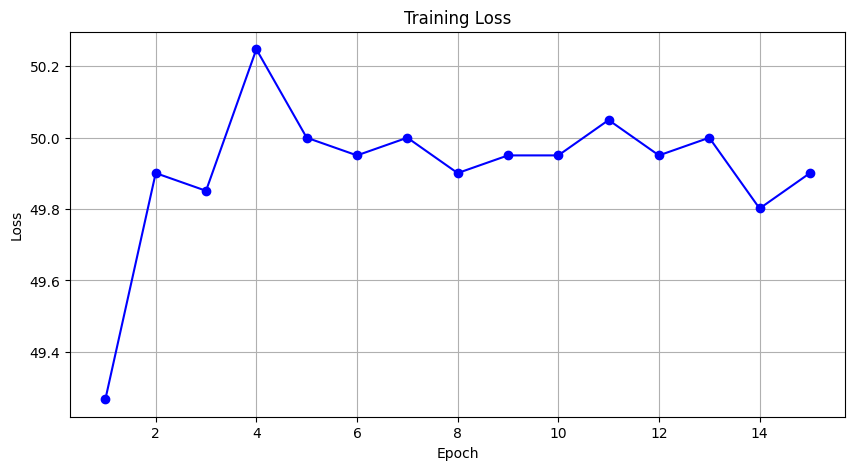

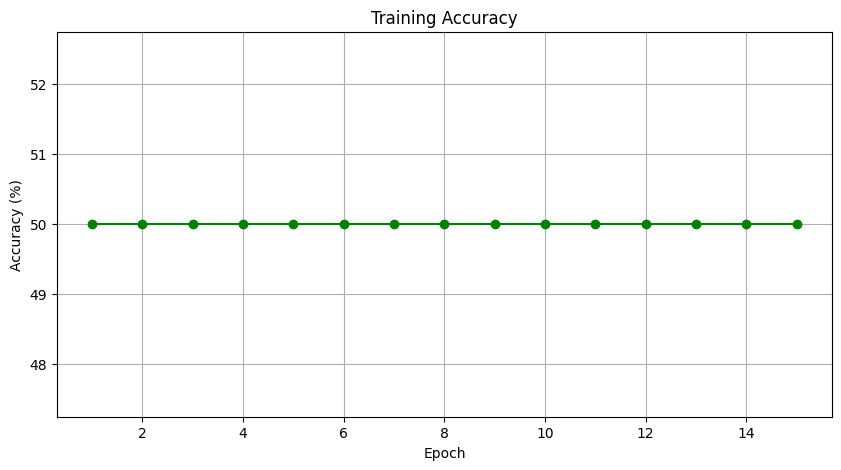

In [24]:
train_model(15, lr = 0.01, batch_size=32)

Learning_Rate  = 0.001

Epoch 1, Loss: 0.7237, Accuracy: 54.00%
Epoch 2, Loss: 0.6819, Accuracy: 56.70%
Epoch 3, Loss: 0.6752, Accuracy: 58.45%
Epoch 4, Loss: 0.6699, Accuracy: 58.40%
Epoch 5, Loss: 0.6352, Accuracy: 63.55%
Epoch 6, Loss: 0.5728, Accuracy: 69.80%
Epoch 7, Loss: 0.4732, Accuracy: 76.95%
Epoch 8, Loss: 0.3318, Accuracy: 85.30%
Epoch 9, Loss: 0.2142, Accuracy: 90.25%
Epoch 10, Loss: 0.1111, Accuracy: 96.25%
Epoch 11, Loss: 0.0455, Accuracy: 98.50%
Epoch 12, Loss: 0.0173, Accuracy: 99.75%
Epoch 13, Loss: 0.0083, Accuracy: 99.90%
Epoch 14, Loss: 0.0046, Accuracy: 100.00%
Epoch 15, Loss: 0.0016, Accuracy: 100.00%


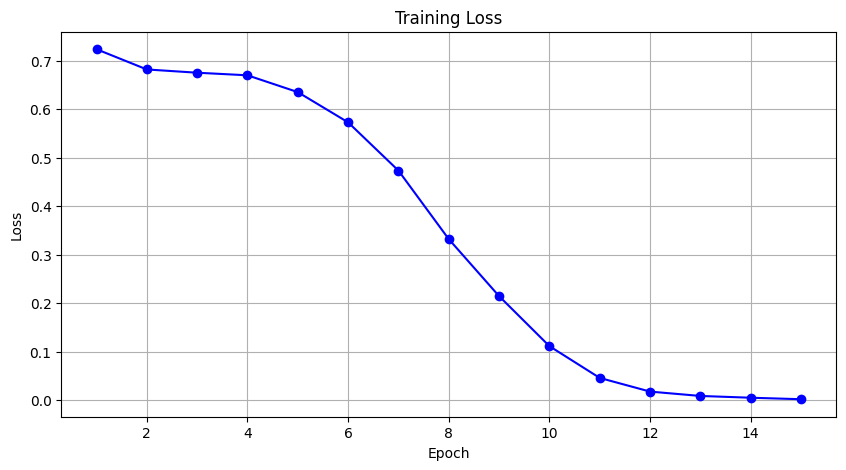

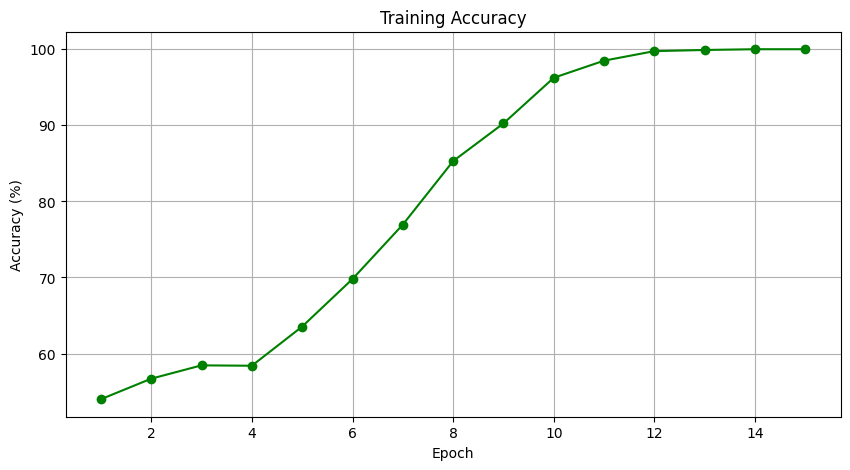

In [25]:
train_model(15, lr = 0.001, batch_size=32)

# Analysis
Model Hyperparameter Analysis:

Here is an anlysis on  the impact of two crucial hyperparameters, learning rate (lr) and batch size, on the performance of the image classification model trained on the custom dataset of cat and dog images.

**Learning Rate (lr):**

The learning rate plays a critical role in controlling the step size during optimization.
The experiment revealed that a learning rate of 0.001 consistently led to the best model performance. This learning rate allowed the model to converge effectively during training.
However, when it is experimented with higher learning rates such as 0.1 and 0.01, the model's performance deteriorated significantly. The model struggled to surpass a 50% accuracy threshold, and training became unstable, characterized by oscillations in both loss and accuracy.

**Batch Size:**

The batch size determines the number of samples processed in each iteration during training.
It is observed that using a batch size of 32 was optimal for our dataset. This batch size facilitated smoother convergence and resulted in the best model performance.
Interestingly, a batch size of 64 also yielded favorable results, outperforming a batch size of 128. While a larger batch size can potentially utilize computational resources more efficiently, it did not translate to better accuracy in our case.

# Testing model from sample Data

In [35]:

model_path = '/content/modellr_0.001batch_32epoch_14'
model = CNNModel().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()


CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [37]:
import random

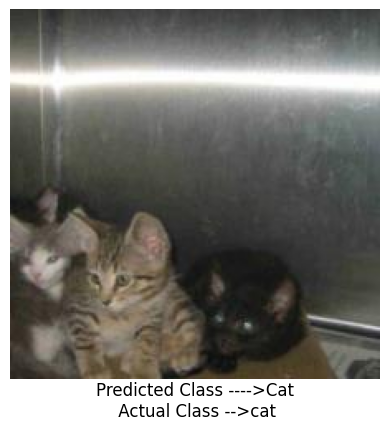

In [55]:
rand_image_num = random.randint(0,len(images)-1)
input_image = images[rand_image_num][0]
input_image = transform(input_image).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(input_image)

prediction = torch.round(output).item()
predicted_class = "Cat" if prediction == 0 else "Dog"

fig, ax = plt.subplots()


ax.imshow(images[rand_image_num][0])
ax.axis('off')

text = "Predicted Class ---->" + predicted_class +"\n Actual Class -->"  + images[rand_image_num][1]
ax.text(0.5, -0.1, text, transform=ax.transAxes, fontsize=12, ha='center')

plt.show()